In [1]:
from fastai.callback.hook import *
from fastbook import *
from fastai.vision.all import *
import fastbook
fastbook.setup_book()


<h4>Class Activation Mapping (CAM)</h4>

<h5>1) DataLoading</h5>

In [2]:
path = untar_data(URLs.PETS)/'images'

In [3]:
Path.BASE_PATH = path

In [4]:
get_image_files(path)

(#7390) [Path('Abyssinian_1.jpg'),Path('Abyssinian_10.jpg'),Path('Abyssinian_100.jpg'),Path('Abyssinian_101.jpg'),Path('Abyssinian_102.jpg'),Path('Abyssinian_103.jpg'),Path('Abyssinian_104.jpg'),Path('Abyssinian_105.jpg'),Path('Abyssinian_106.jpg'),Path('Abyssinian_107.jpg')...]

In [5]:
def is_cat(x): return x[0].isupper()

dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=21,
    label_func=is_cat, item_tfms=Resize(224))

<h5>2) Fine-Tuning</h5>

In [6]:
#fine-tune for one epoch
learner = vision_learner(dls, resnet34, metrics=error_rate)
#learner.fine_tune(1)

c:\Users\yak\MiniConda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yak\MiniConda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
learner.model[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

<h5>3) CAM Construction (only works for the last layer)</h5>

In [8]:
img = PILImage.create(image_cat())
x, = first(dls.test_dl([img]))
x.shape

torch.Size([1, 3, 224, 224])

<Axes: >

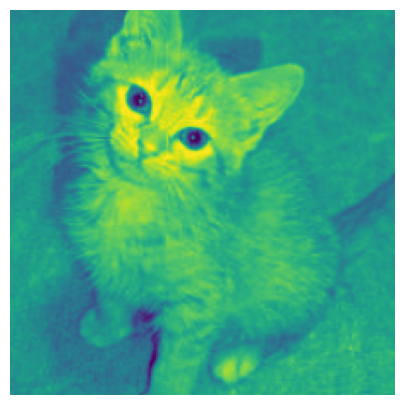

In [9]:
show_image(x[0,0])

In [10]:
#Hook Function
class Hook():
    def hook_func(self, m, i, o): #model, input, output
        self.stored = o.detach().clone()

In [11]:
hook_output = Hook()
hook = learner.model[0].register_forward_hook(hook_output.hook_func)

In [12]:
with torch.no_grad(): 
    output = learner.model.eval()(x)

In [13]:
act = hook_output.stored[0]

In [14]:
F.softmax(output, dim=-1)

TensorImage([[0.1696, 0.8304]])

In [15]:
wm = learner.model[1][-1].weight, act.shape
isinstance(wm[0], Tuple)


False

In [16]:
cammap = torch.einsum('ck, kij -> cij', wm[0], act)
cammap.shape

torch.Size([2, 7, 7])

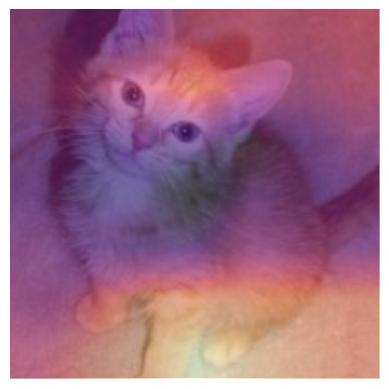

In [17]:
xdecode = TensorImage(dls.train.decode((x,))[0][0])
_, ax = plt.subplots()
xdecode.show(ctx=ax)
ax.imshow(cammap[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
          interpolation='bilinear', cmap='magma')


In [18]:
#to prevent memory leak
# Memory leak occurs when programmers c
# reate a memory in heap and forget to delete it.
hook.remove()

<h5>Auto-Hook</h5>

In [27]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)

    def hook_func(self, m, i, o): self.stored = o[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()


In [20]:
with Hook(learner.model[0]) as hook:
    with torch.no_grad():
        output = learner.model.eval()(x.cpu())
    act = hook.stored

<h5>4) Gradient CAM (Any Layer)</h5>

<h6>Backward Hook</h6>

In [24]:
#cls: stands for class
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)
    def hook_func(self, m, gin, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [28]:
cls = 1
with HookBwd(learner.model[0]) as hookbwd:
    with Hook(learner.model[0]) as hook:
        out = learner.model.eval()(x.cpu())
        print(out)
        act = hook.stored
    out[0, cls].backward()
    grad = hookbwd.stored

c:\Users\yak\MiniConda3\lib\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


TensorImage([[1.0033, 2.5917]], grad_fn=<AliasBackward0>)


In [35]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cammap = (w*act[0]).sum(0)

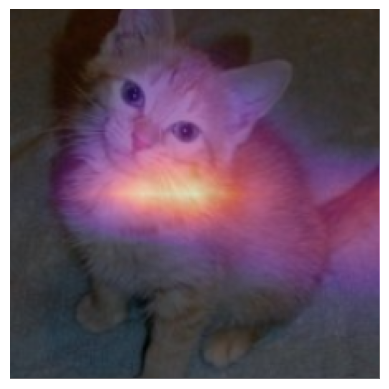

In [38]:
_,ax = plt.subplots()
xdecode.show(ctx=ax)
ax.imshow(cammap.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma')

<h5>-> Grad-CAM on second-to-last Layer</h5>

In [40]:
cls = 1
with HookBwd(learner.model[0][-2]) as hookbwd:
    with Hook(learner.model[0][-2]) as hook:
        out = learner.model.eval()(x.cpu())
        print(out)
        act = hook.stored
    out[0, cls].backward()
    grad = hookbwd.stored

c:\Users\yak\MiniConda3\lib\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


TensorImage([[1.0033, 2.5917]], grad_fn=<AliasBackward0>)


In [41]:
w = grad[0].mean(dim=[1, 2], keepdim=True)
cam_map = (w * act).sum(0)


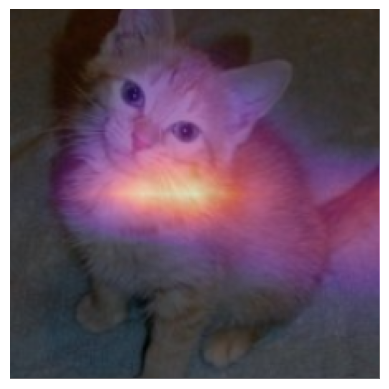

In [45]:
_, ax = plt.subplots()
xdecode.show(ctx=ax)
ax.imshow(cammap.detach().cpu(), alpha=0.6, extent=(0, 224, 224, 0),
          interpolation='bilinear', cmap='magma')
